In [23]:
#Dependencias
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [25]:
#Carga y preparacion de dataset de dataset
df = pd.read_csv("http://www2.udec.cl/~jorgecastillo/AirPassengers.txt")

df.columns = [
    'month',
    'passengers'
]

df.index = pd.Index(sm.tsa.datetools.dates_from_range('1949m1', '1960m12'))
#df

<AxesSubplot:>

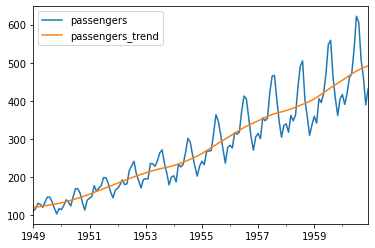

In [21]:
#1.A -  Para el caso del calculo de tendencia de la serie de tiempo, se grafica los datos a partir de la aplicacion del filtro Hodrick-Prescott,
#       dando como resultado, que esta tendencia es CRECIENTE y MULTIPLICATIVA en el periodo de estudio

hp = sm.tsa.filters.hpfilter(df['passengers'])

df['passengers_cycle'] = hp[0]
df['passengers_trend'] = hp[1]

df[['passengers','passengers_trend']].plot()

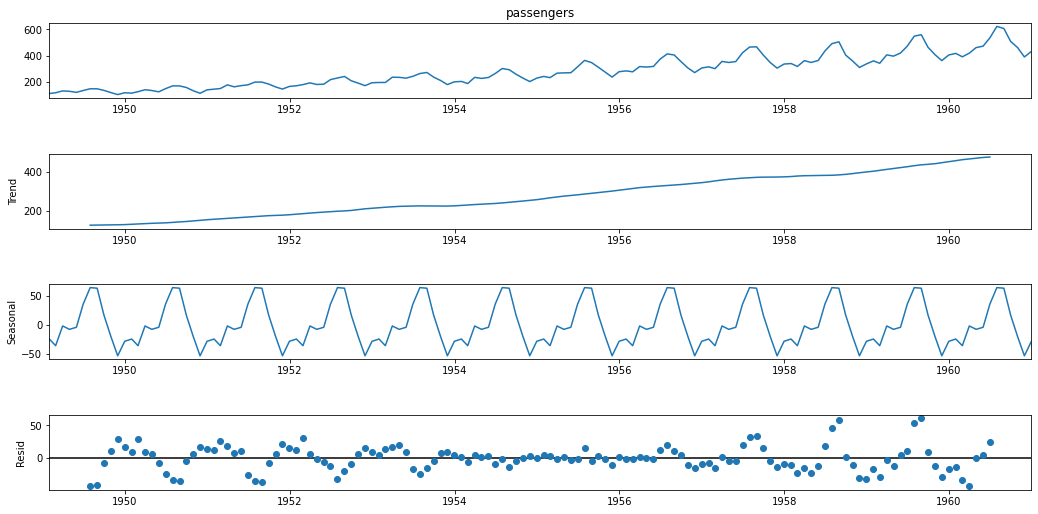

In [32]:
decomposition = seasonal_decompose(df['passengers'].interpolate("linear"))

fig = decomposition.plot()
fig.set_size_inches(16, 8)

In [33]:
#1.B -  Para el caso de calculo de estacionalidad de la serie de tiempo, se grafican los datos con el metodo seasonal_decompose() con la variable de pasajeros como argumento,
#       dando esto un componente estacional marcado para los años de estudio

In [24]:
#1.C -
# - Irregularidades y Shocks Aleatorios: Dentro del caso de estudio, se puede apreciar de que no hay homocedasticidad en todo el residuo, 
#   solo podia haber desde el año 1954 hasta aproximadamente el primer semestre el año 1957, de ahi en adelante, se precentan hechos como en el segundo semestre de 1958 y Q3 1959
# - Estacionariedad: se puede apreciar mediante la prueba de Dickey-Fuller, que la serie de tiempo no es estacionaria

adfuller(df['passengers'])

(0.8153688792060472,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)